# Deep Learning - based Movie Recommendation System

## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from tmdbv3api import TMDb, Movie

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

import copy

## Loading the dataset

### Merging movies and links in order to be able to use the tmdbId to get more info about each movie

In [49]:
links_df = pd.read_csv('./ml-latest-small/links.csv')
movies_df = pd.read_csv('./ml-latest-small/movies.csv')
ratings_df = pd.read_csv('./ml-latest-small/ratings.csv')

movies_links = movies_df.merge(links_df, on="movieId", how="left")
movies_links.head()

,movieId,title,genres,imdbId,tmdbId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,113497,8844.0
2,3,Grumpier Old Men (1995),Comedy|Romance,113228,15602.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,114885,31357.0
4,5,Father of the Bride Part II (1995),Comedy,113041,11862.0


In [9]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [125]:
ratings_df.sample(5)

,userId,movieId,rating,timestamp
6404,43,587,5.0,848993816
43407,290,2919,4.0,974942150
56094,371,1258,5.0,1407692597
22779,156,1060,4.0,1106854107
38478,264,1580,4.5,1136978772


### The method below retrieves data about each movie entry in the dataset. It takes about half an hour to run.

In [10]:
tmdb = TMDb()
tmdb.api_key = "c6dcffa24617dd0f0d2279070c5d7bca"

movie_api = Movie()

def get_tmdb_data(tmdb_id):
    try:
        movie = movie_api.details(int(tmdb_id))

        return pd.Series({
            "budget": movie.budget,
            "tmdb_rating": movie.vote_average,
            "vote_count": movie.vote_count,
            "revenue": movie.revenue,
            "popularity": movie.popularity,
            "budget": movie.budget
        })
    except:
        return pd.Series({"budget": None, "tmdb_rating": None, "vote_count": None, "revenue": None, "popularity": None, "budget": None})


movies_links_tmdb = movies_links.assign(**movies_links["tmdbId"].apply(get_tmdb_data))

movies_links_tmdb.head()

,movieId,title,genres,imdbId,tmdbId,budget,tmdb_rating,vote_count,revenue,popularity
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,30000000.0,8.000,18705.0,394436586.0,18.7304
1,2,Jumanji (1995),Adventure|Children|Fantasy,113497,8844.0,65000000.0,7.235,10697.0,262821940.0,2.7290
2,3,Grumpier Old Men (1995),Comedy|Romance,113228,15602.0,25000000.0,6.500,393.0,71500000.0,1.0561
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,114885,31357.0,16000000.0,6.300,170.0,81452156.0,0.9145
4,5,Father of the Bride Part II (1995),Comedy,113041,11862.0,0.0,6.230,749.0,76594107.0,1.4142


In [34]:
#movies_links_tmdb.to_csv("tmdb_metadata.csv")

In [50]:
movies_links_tmdb = pd.read_csv("tmdb_metadata.csv")

In [51]:
movies_links_tmdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   9742 non-null   int64  
 1   movieId      9742 non-null   int64  
 2   title        9742 non-null   object 
 3   genres       9742 non-null   object 
 4   imdbId       9742 non-null   int64  
 5   tmdbId       9734 non-null   float64
 6   budget       9622 non-null   float64
 7   tmdb_rating  9622 non-null   float64
 8   vote_count   9622 non-null   float64
 9   revenue      9622 non-null   float64
 10  popularity   9622 non-null   float64
dtypes: float64(6), int64(3), object(2)
memory usage: 837.3+ KB


In [52]:
movies_links_tmdb.isnull().sum()

Unnamed: 0       0
movieId          0
title            0
genres           0
imdbId           0
tmdbId           8
budget         120
tmdb_rating    120
vote_count     120
revenue        120
popularity     120
dtype: int64

In [53]:
columns_to_fill = ["budget", "tmdb_rating", "vote_count", "revenue", "popularity"]

for col in columns_to_fill:
    mean_value = movies_links_tmdb[col].mean()
    movies_links_tmdb[col] = movies_links_tmdb[col].fillna(mean_value)

In [54]:
duplicate_rows = movies_links_tmdb[movies_links_tmdb.duplicated()]
print(f"Duplicate values: {duplicate_rows.size}")

Duplicate values: 0


### I will remove the id features since they are not useful for the recommendation system

In [55]:
movies_df = movies_links_tmdb.drop(columns=["imdbId", 'tmdbId'])

In [56]:
movies_df.describe()

,Unnamed: 0,movieId,budget,tmdb_rating,vote_count,revenue,popularity
count,9742.000000,9742.000000,9.742000e+03,9742.000000,9742.000000,9.742000e+03,9742.000000
mean,4870.500000,42200.353623,1.888222e+07,6.517044,1610.633340,5.653160e+07,2.171219
std,2812.417495,52160.494854,3.421830e+07,0.847868,3154.564785,1.388796e+08,2.811279
min,0.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000
25%,2435.250000,3248.250000,0.000000e+00,6.000000,149.250000,0.000000e+00,0.686750
50%,4870.500000,7300.000000,4.200000e+06,6.553500,476.500000,7.927918e+06,1.329550
75%,7305.750000,76232.000000,2.200000e+07,7.100000,1610.633340,5.007634e+07,2.487100
max,9741.000000,193609.000000,3.790000e+08,8.900000,37237.000000,2.923706e+09,67.931300


In [57]:
object_cols = [var for var in movies_df.columns if movies_df[var].dtypes == 'object']
numeric_cols = [var for var in movies_df.columns if movies_df[var].dtypes == 'float64']

print(f'Object columns: {object_cols}\n')
print(f'Float columns: {numeric_cols}')

Object columns: ['title', 'genres']

Float columns: ['budget', 'tmdb_rating', 'vote_count', 'revenue', 'popularity']


In [58]:
movies_df.sample(5)

,Unnamed: 0,movieId,title,genres,budget,tmdb_rating,vote_count,revenue,popularity
616,616,781,Stealing Beauty (1996),Drama,10000000.0,6.700,569.0,4800000.0,1.7838
120,120,147,"Basketball Diaries, The (1995)",Drama,2000000.0,7.398,2029.0,2381087.0,3.3981
7719,7719,90405,In Time (2011),Crime|Sci-Fi|Thriller,40000000.0,6.968,11525.0,173900000.0,11.3396
136,136,163,Desperado (1995),Action|Romance|Western,7000000.0,6.922,2907.0,25405445.0,4.0673
2670,2670,3573,Carnosaur 2 (1995),Horror|Sci-Fi,0.0,4.300,50.0,0.0,0.2628


In [59]:
movies_df["year"] = movies_df["title"].str.extract(r"\((\d{4})\)").astype("float64")

movies_df['year'].isnull().sum()

np.int64(13)

In [60]:
movies_df = movies_df.dropna()

In [61]:
unique_years = set(elem for elem in movies_df["year"])

print(unique_years)

{1902.0, 1903.0, 1908.0, 1915.0, 1916.0, 1917.0, 1919.0, 1920.0, 1921.0, 1922.0, 1923.0, 1924.0, 1925.0, 1926.0, 1927.0, 1928.0, 1929.0, 1930.0, 1931.0, 1932.0, 1933.0, 1934.0, 1935.0, 1936.0, 1937.0, 1938.0, 1939.0, 1940.0, 1941.0, 1942.0, 1943.0, 1944.0, 1945.0, 1946.0, 1947.0, 1948.0, 1949.0, 1950.0, 1951.0, 1952.0, 1953.0, 1954.0, 1955.0, 1956.0, 1957.0, 1958.0, 1959.0, 1960.0, 1961.0, 1962.0, 1963.0, 1964.0, 1965.0, 1966.0, 1967.0, 1968.0, 1969.0, 1970.0, 1971.0, 1972.0, 1973.0, 1974.0, 1975.0, 1976.0, 1977.0, 1978.0, 1979.0, 1980.0, 1981.0, 1982.0, 1983.0, 1984.0, 1985.0, 1986.0, 1987.0, 1988.0, 1989.0, 1990.0, 1991.0, 1992.0, 1993.0, 1994.0, 1995.0, 1996.0, 1997.0, 1998.0, 1999.0, 2000.0, 2001.0, 2002.0, 2003.0, 2004.0, 2005.0, 2006.0, 2007.0, 2008.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013.0, 2014.0, 2015.0, 2016.0, 2017.0, 2018.0}


### There are many unique years. I will group them into decades

In [62]:
movies_df["decade"] = (movies_df["year"] // 10) * 10

movies_df = movies_df.drop(columns=['year'])

movies_df['decade'].sample(5)

6869    2000.0
4748    1930.0
4077    2000.0
4717    1980.0
3750    2000.0
Name: decade, dtype: float64

In [63]:
movies_df["genres"] = movies_df["genres"].apply(lambda x: x.split("|") if isinstance(x, str) else [])

unique_genres = set(g for genre_list in movies_df["genres"] for g in genre_list)

genre_to_id = {genre: idx for idx, genre in enumerate(unique_genres)}

id_to_genre = {v: k for k, v in genre_to_id.items()}

movies_df["genre_ids"] = movies_df["genres"].apply(lambda x: [genre_to_id.get(g, -1) for g in x])

all_genre_ids = [g for sublist in movies_df["genre_ids"] for g in sublist]

In [64]:
categoric_cols = ['decade', 'genre_ids']

## Lets plot a few of these features

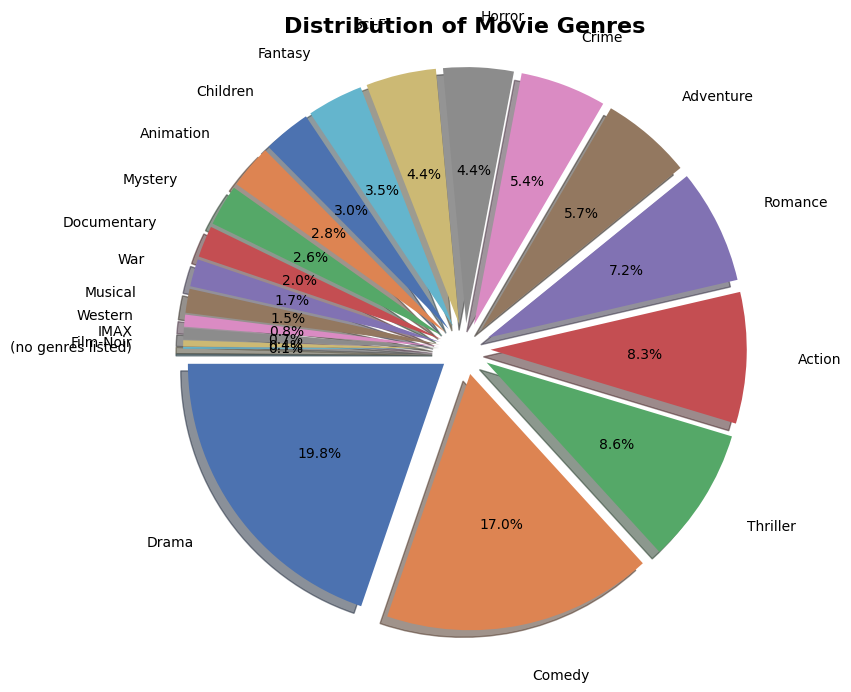

In [65]:
genre_counts = pd.Series(all_genre_ids).value_counts()

genre_counts.index = genre_counts.index.map(id_to_genre)

palettes = ["pastel", "muted", "deep", "bright", "dark"]
colors = sns.color_palette(random.choice(palettes), len(genre_counts))

explode = [0.1] * len(genre_counts)

plt.figure(figsize=(8, 8))
plt.pie(
    genre_counts, 
    labels=genre_counts.index,
    autopct='%1.1f%%', 
    startangle=180,
    colors=colors,
    explode=explode,  
    shadow=True,
    labeldistance=1.2
)

plt.title('Distribution of Movie Genres', fontsize=16, fontweight='bold')
plt.axis('equal')  
plt.show()

In [66]:
movies_df = movies_df.drop(columns=["genres"])

movies_df.sample(5)

,Unnamed: 0,movieId,title,budget,tmdb_rating,vote_count,revenue,popularity,decade,genre_ids
3267,3267,4422,Cries and Whispers (Viskningar och rop) (1972),400000.0,7.900,708.0,0.0,1.0986,1970.0,[16]
5501,5501,26394,"Turning Point, The (1977)",0.0,6.600,61.0,0.0,0.3818,1970.0,"[16, 17]"
5760,5760,31114,Imaginary Heroes (2004),10000000.0,6.509,110.0,0.0,0.6396,2000.0,"[11, 16]"
8133,8133,101612,Admission (2013),13000000.0,5.600,618.0,18637201.0,1.3254,2010.0,"[11, 17]"
284,284,326,To Live (Huozhe) (1994),0.0,8.100,326.0,0.0,1.5349,1990.0,[16]


/tmp/ipykernel_20387/3201744222.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=movies_df, x="decade", palette="Set2")


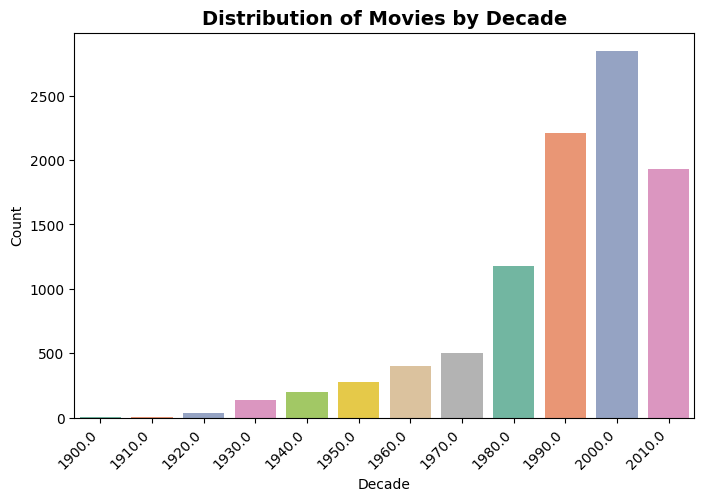

In [67]:
decade_labels = sorted(movies_df["decade"].unique())
movies_df["decade"] = pd.Categorical(movies_df["decade"], categories=decade_labels, ordered=True)

plt.figure(figsize=(8, 5))
sns.countplot(data=movies_df, x="decade", palette="Set2")

plt.title('Distribution of Movies by Decade', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.xlabel("Decade")
plt.ylabel("Count")

plt.show()

In [68]:
decade_mapping = {decade: idx for idx, decade in enumerate(sorted(movies_df["decade"].unique()))}

movies_df["decade"] = movies_df["decade"].map(decade_mapping)

## Now lets plot the numerical data

### This will help us tackle the skewness of the dataset

<Figure size 1200x1200 with 0 Axes>

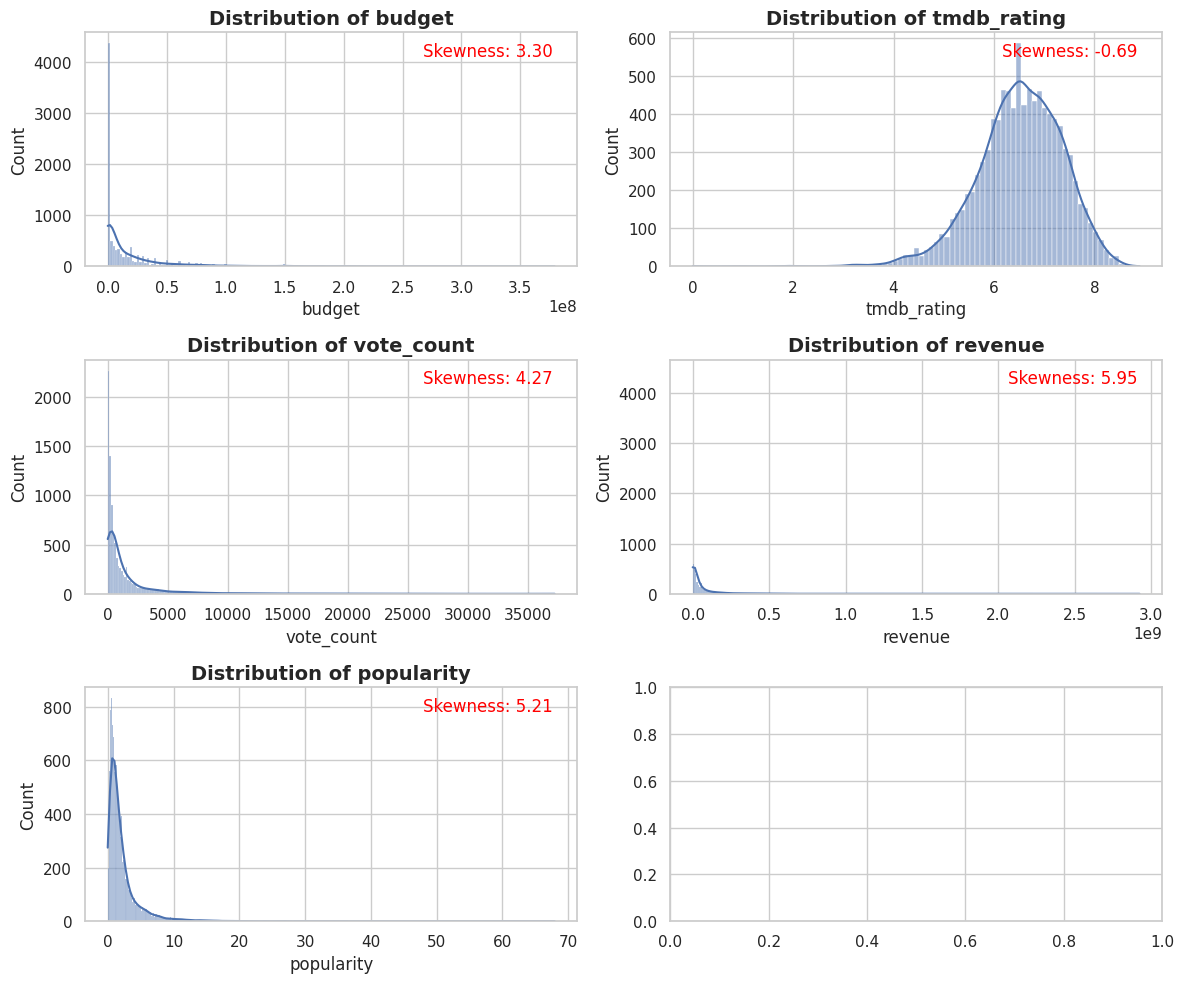

In [69]:
from scipy.stats import skew

plt.figure(figsize=(12, 12))
sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 2, figsize=(12, 10))

axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    skewness = skew(movies_df[col].dropna())
    
    sns.histplot(movies_df[col], ax=axes[i], kde=True)
    axes[i].set_title(f'Distribution of {col}', fontsize=14, fontweight='bold')
    
    axes[i].annotate(f"Skewness: {skewness:.2f}",
                     xy=(0.95, 0.9), xycoords='axes fraction',
                     ha='right', fontsize=12, color='red')


plt.tight_layout()
plt.show()

In [70]:
skewness_values = {col: skew(movies_df[col].dropna()) for col in numeric_cols}

skewness_series = pd.Series(skewness_values, name='Skewness')
skewness_series.index.name = 'Numerical Column'
skewness_series = skewness_series.sort_values(ascending=False)

print(skewness_series)

Numerical Column
revenue        5.952702
popularity     5.208911
vote_count     4.268244
budget         3.295431
tmdb_rating   -0.687240
Name: Skewness, dtype: float64


### The method applies for skewness is yeo-johnson transformation, which is quite a general transformation method

In [71]:
from sklearn.preprocessing import PowerTransformer

numerical_df = pd.DataFrame()

for col, col_skew in skewness_series.items():
    print(f"Processing column: {col}, Skewness: {col_skew}")

    if abs(col_skew) > 0.5: #moderate skewness
        
        pt = PowerTransformer(method='yeo-johnson')
        
        transformed_col = pt.fit_transform(movies_df[[col]])
        
        numerical_df[col] = pd.Series(transformed_col.flatten(), index=movies_df.index)
        
        print(f"Applied Yeo-Johnson transformation to '{col}'")
        
    else:
        
        numerical_df[col] = movies_df[col]  # Retain the original column if skewness is within range
        print(f"No transformation applied to '{col}' (skewness within acceptable range)")

    print("--------------------")

Processing column: revenue, Skewness: 5.952702171081108
Applied Yeo-Johnson transformation to 'revenue'
--------------------
Processing column: popularity, Skewness: 5.208910827924571
Applied Yeo-Johnson transformation to 'popularity'
--------------------
Processing column: vote_count, Skewness: 4.268244023361453
Applied Yeo-Johnson transformation to 'vote_count'
--------------------
Processing column: budget, Skewness: 3.2954308326281683
Applied Yeo-Johnson transformation to 'budget'
--------------------
Processing column: tmdb_rating, Skewness: -0.6872403471680868
Applied Yeo-Johnson transformation to 'tmdb_rating'
--------------------


<Figure size 1200x1200 with 0 Axes>

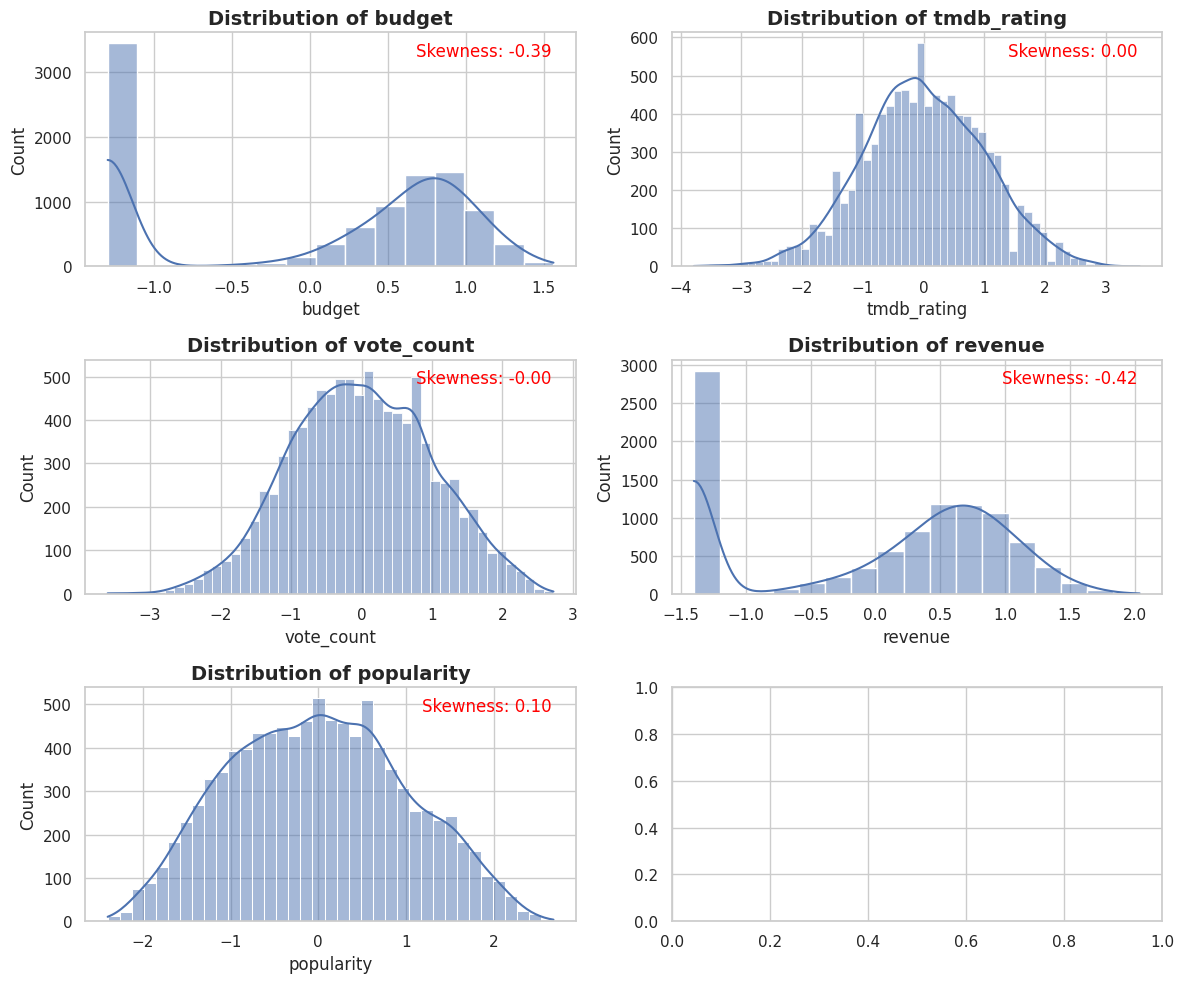

In [72]:
from scipy.stats import skew

plt.figure(figsize=(12, 12))
sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 2, figsize=(12, 10))

axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    skewness = skew(numerical_df[col].dropna())
    
    sns.histplot(numerical_df[col], ax=axes[i], kde=True)
    axes[i].set_title(f'Distribution of {col}', fontsize=14, fontweight='bold')
    
    axes[i].annotate(f"Skewness: {skewness:.2f}",
                     xy=(0.95, 0.9), xycoords='axes fraction',
                     ha='right', fontsize=12, color='red')


plt.tight_layout()
plt.show()

### Skewness is far better now, it looks like a normal distribution

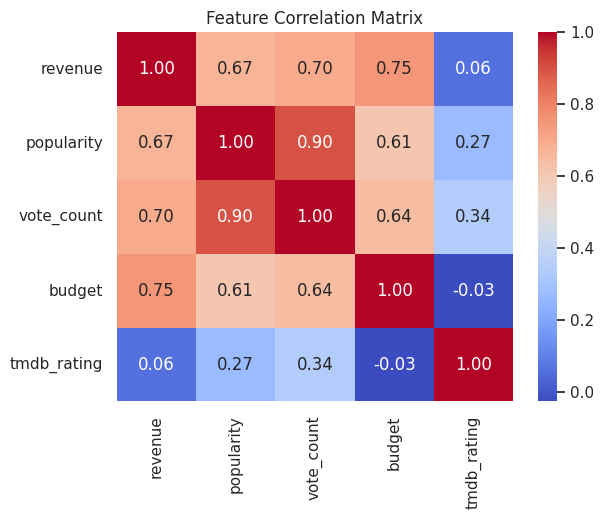

In [73]:
sns.heatmap(numerical_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

### Now we will normalize the numeric features

In [74]:
numerical_df.head(5)

,revenue,popularity,vote_count,budget,tmdb_rating
0,1.370347,2.291719,2.279266,0.900384,2.008515
1,1.249156,0.817261,1.921947,1.088485,0.859164
2,0.889716,-0.285263,-0.130494,0.857706,-0.106017
3,0.923792,-0.450731,-0.633862,0.755841,-0.345848
4,0.907661,0.058348,0.261938,-1.298149,-0.427532


In [75]:
scaler = MinMaxScaler()

numerical_scaled = scaler.fit_transform(numerical_df)

numerical_df = pd.DataFrame(numerical_scaled, columns=numerical_df.columns, index=numerical_df.index)

numerical_df.head()

,revenue,popularity,vote_count,budget,tmdb_rating
0,0.805549,0.922956,0.929766,0.768203,0.788857
1,0.770320,0.633041,0.873282,0.833929,0.632271
2,0.665834,0.416257,0.548836,0.753291,0.500776
3,0.675739,0.383722,0.469264,0.717697,0.468102
4,0.671050,0.483820,0.610871,0.000000,0.456974


## Now we will merge this dataset to the ratings dataset

In [76]:
movies_df = movies_df.drop(columns=['title'])

movies_df[numerical_df.columns] = numerical_df

movies_df.head()

,Unnamed: 0,movieId,budget,tmdb_rating,vote_count,revenue,popularity,decade,genre_ids
0,0,1,0.768203,0.788857,0.929766,0.805549,0.922956,9,"[18, 5, 15, 11, 13]"
1,1,2,0.833929,0.632271,0.873282,0.770320,0.633041,9,"[18, 15, 13]"
2,2,3,0.753291,0.500776,0.548836,0.665834,0.416257,9,"[11, 17]"
3,3,4,0.717697,0.468102,0.469264,0.675739,0.383722,9,"[11, 16, 17]"
4,4,5,0.000000,0.456974,0.610871,0.671050,0.483820,9,[11]


In [77]:
final_df = movies_df.merge(ratings_df, on="movieId", how="left")

final_df.head()

,Unnamed: 0,movieId,budget,tmdb_rating,vote_count,revenue,popularity,decade,genre_ids,userId,rating,timestamp
0,0,1,0.768203,0.788857,0.929766,0.805549,0.922956,9,"[18, 5, 15, 11, 13]",1.0,4.0,9.649827e+08
1,0,1,0.768203,0.788857,0.929766,0.805549,0.922956,9,"[18, 5, 15, 11, 13]",5.0,4.0,8.474350e+08
2,0,1,0.768203,0.788857,0.929766,0.805549,0.922956,9,"[18, 5, 15, 11, 13]",7.0,4.5,1.106636e+09
3,0,1,0.768203,0.788857,0.929766,0.805549,0.922956,9,"[18, 5, 15, 11, 13]",15.0,2.5,1.510578e+09
4,0,1,0.768203,0.788857,0.929766,0.805549,0.922956,9,"[18, 5, 15, 11, 13]",17.0,4.5,1.305696e+09


In [78]:
final_df.isnull().sum()

Unnamed: 0      0
movieId         0
budget          0
tmdb_rating     0
vote_count      0
revenue         0
popularity      0
decade          0
genre_ids       0
userId         18
rating         18
timestamp      18
dtype: int64

## This generated me a mistake in the model because i had a rating of value NaN. I will remove this row

In [79]:
final_df = final_df.dropna()

### We will also apply time-decay weighted ratings in order for the recent ratings to have more importance

In [80]:
final_df["rating_date"] = pd.to_datetime(final_df["timestamp"], unit="s")

final_df["days_since_rating"] = (final_df["rating_date"].max() - final_df["rating_date"]).dt.days

final_df[["userId", "movieId", "rating", "rating_date", "days_since_rating"]].head()

,userId,movieId,rating,rating_date,days_since_rating
0,1.0,1,4.0,2000-07-30 18:45:03,6629
1,5.0,1,4.0,1996-11-08 06:36:02,7990
2,7.0,1,4.5,2005-01-25 06:52:26,4990
3,15.0,1,2.5,2017-11-13 12:59:30,315
4,17.0,1,4.5,2011-05-18 05:28:03,2686


### Reduce the influence of older ratings with exponential decay.

In [81]:
final_df["time_weight"] = np.exp(-0.001 * final_df["days_since_rating"])
final_df["weighted_rating"] = final_df["rating"] * final_df["time_weight"]

final_df = final_df.drop(columns=["timestamp", "rating_date", "days_since_rating", "time_weight"])

final_df.head()

,Unnamed: 0,movieId,budget,tmdb_rating,vote_count,revenue,popularity,decade,genre_ids,userId,rating,weighted_rating
0,0,1,0.768203,0.788857,0.929766,0.805549,0.922956,9,"[18, 5, 15, 11, 13]",1.0,4.0,0.005286
1,0,1,0.768203,0.788857,0.929766,0.805549,0.922956,9,"[18, 5, 15, 11, 13]",5.0,4.0,0.001355
2,0,1,0.768203,0.788857,0.929766,0.805549,0.922956,9,"[18, 5, 15, 11, 13]",7.0,4.5,0.030625
3,0,1,0.768203,0.788857,0.929766,0.805549,0.922956,9,"[18, 5, 15, 11, 13]",15.0,2.5,1.824472
4,0,1,0.768203,0.788857,0.929766,0.805549,0.922956,9,"[18, 5, 15, 11, 13]",17.0,4.5,0.306689


In [82]:
numerical_cols = ["budget", "tmdb_rating", "vote_count", "revenue", "popularity"]


## We will split the dataset into test and train datasets

### We have to remap the ids first

### Example:

### Before:
```
0     1.0
1     5.0
2     7.0
3    15.0
4    17.0
Name: userId, dtype: float64
```
#### After:
```
0    0
1    1
2    2
3    3
4    4
Name: userId, dtype: int64
```

In [83]:
final_df["genre_ids"] = final_df["genre_ids"].apply(lambda x: [int(g) for g in x])

# this ensures the ids are continuous and also start from 0

user_mapping = {user_id: idx for idx, user_id in enumerate(final_df["userId"].unique())}
movie_mapping = {movie_id: idx for idx, movie_id in enumerate(final_df["movieId"].unique())}

final_df["userId"] = final_df["userId"].map(user_mapping)
final_df["movieId"] = final_df["movieId"].map(movie_mapping)

### This is a necessary check to ensure indexes dont have any issues

In [84]:
train_df, test_df = train_test_split(final_df, test_size=0.2, random_state=42)

num_users = final_df["userId"].nunique()
num_movies = final_df["movieId"].nunique()
num_genres = final_df["genre_ids"].explode().nunique() + 1  # +1 for padding
num_decades = final_df["decade"].nunique()

print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")
print(f"User ID: {train_df['userId'].max()}, Num Users: {num_users}")
print(f"Movie ID: {train_df['movieId'].max()}, Num Movies: {num_movies}")
print(f"Genre ID: {train_df['genre_ids'].explode().max()}, Num Genres: {num_genres}")
print(f"Decade ID: {train_df['decade'].max()}, Num Decades: {num_decades}")


Train size: 80654, Test size: 20164
User ID: 609, Num Users: 610
Movie ID: 9709, Num Movies: 9711
Genre ID: 19, Num Genres: 21
Decade ID: 11, Num Decades: 12


### Convert categorical data into tensors

In [85]:
train_users = torch.tensor(train_df["userId"].values, dtype=torch.long)
train_movies = torch.tensor(train_df["movieId"].values, dtype=torch.long)
train_ratings = torch.tensor(train_df["weighted_rating"].values, dtype=torch.float32)
train_decades = torch.tensor(train_df["decade"].values, dtype=torch.long)


test_users = torch.tensor(test_df["userId"].values, dtype=torch.long)
test_movies = torch.tensor(test_df["movieId"].values, dtype=torch.long)
test_ratings = torch.tensor(test_df["weighted_rating"].values, dtype=torch.float32)
test_decades = torch.tensor(test_df["decade"].values, dtype=torch.long)


In [86]:
genre_tensor_list_train = [torch.tensor(g, dtype=torch.long) for g in train_df["genre_ids"]]
train_genres = pad_sequence(genre_tensor_list_train, batch_first=True, padding_value=0)

genre_tensor_list_test = [torch.tensor(g, dtype=torch.long) for g in test_df["genre_ids"]]
test_genres = pad_sequence(genre_tensor_list_test, batch_first=True, padding_value=0)

In [87]:
train_numerical = torch.tensor(train_df[numerical_cols].values, dtype=torch.float32)
test_numerical = torch.tensor(test_df[numerical_cols].values, dtype=torch.float32)

### We will now load the dataset into the DataLoaders in order to be able to use it in the model in an efficient way

In [88]:
train_dataset = TensorDataset(train_users, train_movies, train_genres, train_decades, train_numerical, train_ratings)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = TensorDataset(test_users, test_movies, test_genres, test_decades, test_numerical, test_ratings)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Architecture of the model

In [89]:
class NCF(nn.Module):
    def __init__(self, num_users, num_movies, num_genres, num_decades, embedding_dim, num_numerical_features):
        super(NCF, self).__init__()

        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.movie_embedding = nn.Embedding(num_movies, embedding_dim)
        self.genre_embedding = nn.Embedding(num_genres, embedding_dim, padding_idx=0)
        self.decade_embedding = nn.Embedding(num_decades, embedding_dim)

        self.numerical_fc = nn.Linear(num_numerical_features, embedding_dim)

        self.fc1 = nn.Linear(embedding_dim * 5, 128)
        self.fc2 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 1)

        self.relu = nn.ReLU()

    def forward(self, user_id, movie_id, genre_id, decade_id, numerical_features):
        user_emb = self.user_embedding(user_id)
        movie_emb = self.movie_embedding(movie_id)
        genre_emb = self.genre_embedding(genre_id).mean(dim=1)
        decade_emb = self.decade_embedding(decade_id)
        numerical_emb = self.numerical_fc(numerical_features)

        x = torch.cat([user_emb, movie_emb, genre_emb, decade_emb, numerical_emb], dim=1)

        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.output(x)
    
embedding_dim = 8
num_numerical_features = len(numerical_cols)

model = NCF(num_users, num_movies, num_genres, num_decades, embedding_dim, num_numerical_features)


In [90]:
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for users, movies, genres, decades, numerical_features, ratings in train_loader:
            optimizer.zero_grad()
            preds = model(users, movies, genres, decades, numerical_features).squeeze()
            loss = criterion(preds, ratings)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")
    return model

In [91]:
def evaluate_model(model, data_loader):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for users, movies, genres, decades, numerical_features, ratings in data_loader:
            output = model(users, movies, genres, decades, numerical_features).squeeze()
            preds.extend(output.cpu().numpy())
            targets.extend(ratings.cpu().numpy())

    rmse = root_mean_squared_error(targets, preds)
    mae = mean_absolute_error(targets, preds)
    r2 = r2_score(targets, preds)

    return {
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2
    }

In [94]:
loss_functions = {
    "MSELoss": nn.MSELoss(),
    "L1Loss": nn.L1Loss(),
    "SmoothL1Loss": nn.SmoothL1Loss()
}

results = {}

for name, loss_fn in loss_functions.items():
    print(f"Loss func: {name}\n")

    model_copy = copy.deepcopy(model)
    optimizer = optim.Adam(model_copy.parameters(), lr=0.001)

    trained_model = train_model(model_copy, train_loader, loss_fn, optimizer, num_epochs=30)

    metrics = evaluate_model(trained_model, test_loader)
    results[name] = metrics


Loss func: MSELoss

Epoch 1/30, Loss: 0.4310
Epoch 2/30, Loss: 0.1660
Epoch 3/30, Loss: 0.1261
Epoch 4/30, Loss: 0.1162
Epoch 5/30, Loss: 0.1100
Epoch 6/30, Loss: 0.1058
Epoch 7/30, Loss: 0.1020
Epoch 8/30, Loss: 0.0985
Epoch 9/30, Loss: 0.0961
Epoch 10/30, Loss: 0.0923
Epoch 11/30, Loss: 0.0890
Epoch 12/30, Loss: 0.0859
Epoch 13/30, Loss: 0.0828
Epoch 14/30, Loss: 0.0788
Epoch 15/30, Loss: 0.0754
Epoch 16/30, Loss: 0.0724
Epoch 17/30, Loss: 0.0691
Epoch 18/30, Loss: 0.0659
Epoch 19/30, Loss: 0.0629
Epoch 20/30, Loss: 0.0599
Epoch 21/30, Loss: 0.0573
Epoch 22/30, Loss: 0.0546
Epoch 23/30, Loss: 0.0524
Epoch 24/30, Loss: 0.0495
Epoch 25/30, Loss: 0.0473
Epoch 26/30, Loss: 0.0451
Epoch 27/30, Loss: 0.0429
Epoch 28/30, Loss: 0.0414
Epoch 29/30, Loss: 0.0394
Epoch 30/30, Loss: 0.0379
Loss func: L1Loss

Epoch 1/30, Loss: 0.3488
Epoch 2/30, Loss: 0.1985
Epoch 3/30, Loss: 0.1629
Epoch 4/30, Loss: 0.1494
Epoch 5/30, Loss: 0.1428
Epoch 6/30, Loss: 0.1381
Epoch 7/30, Loss: 0.1353
Epoch 8/30, Los

### Final results:

In [95]:
print("Results:")
results_df = pd.DataFrame(results).T
print(results_df.round(4))

Results:
                RMSE     MAE      R2
MSELoss       0.3779  0.1737  0.8506
L1Loss        0.3513  0.1445  0.8708
SmoothL1Loss  0.3687  0.1663  0.8577
